#Introduction

Build a model that will help you predict the best time to go to the gym and avoid crowds, so you can enjoy a great workout with minimal wait times and no crowds.

Using a Dataframe with the more then 60000 observations about the number of persons at a college gym.

In [58]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [59]:
gym = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/ML/crowdness_gym_data.csv')
gym_c = gym.copy()

# Basic views
print(gym_c.head(3))
print('\n')
print(gym_c.shape)
print('\n')
print(gym_c.info())

   number_people                       date  timestamp  day_of_week  \
0             37  2015-08-14 17:00:11-07:00      61211            4   
1             45  2015-08-14 17:20:14-07:00      62414            4   
2             40  2015-08-14 17:30:15-07:00      63015            4   

   is_weekend  is_holiday  temperature  is_start_of_semester  \
0           0           0        71.76                     0   
1           0           0        71.76                     0   
2           0           0        71.76                     0   

   is_during_semester  month  hour  
0                   0      8    17  
1                   0      8    17  
2                   0      8    17  


(62184, 11)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62184 entries, 0 to 62183
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   number_people         62184 non-null  int64  
 1   date                  62184

* **number_people**: this is the number of people at the gym at each observation. This will be our target variable or label.
* **date**: a string value with the specific date and time information.
* **timestamp**: an integer (int), with the number of seconds since the start of the day (00:00).
* **day_of_week**: an integer (int). 0 is equal to Monday and 6 is equal to Sunday.
* **is_weekend**: a Boolean value defining if this observation happened during a weekend. 1 for yes, 0 for no.
* **is_holiday**: a Boolean value defining if the observation happened during a holiday. 1 for yes, 0 for no.
* **temperature**: a float, defining the temperature during the day of the observation in Fahrenheit.
* **is_startof_semester**: a Boolean defining if the observation happened in the first 2 weeks of a semester. 1 for yes, 0 for no.
* **is_during_semester**: a Boolean defining if the observation happened during the active semester. 1 for yes, 0 for no.
* **month**: an integer (int) defining the month of the year. 1 is equal to January, 12 is equal to December.
* **hour**: an integer (int) for the hour of the day from 0 to 23.

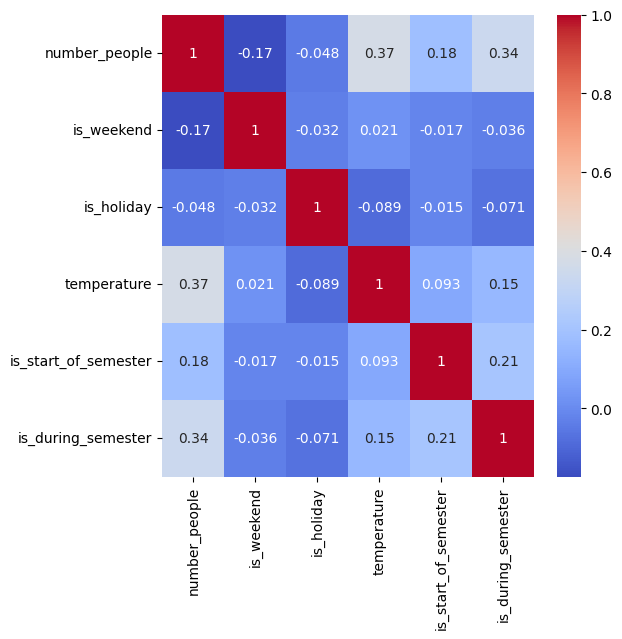

In [60]:
correlation = gym_c.drop(columns = ['date','timestamp','day_of_week','month','hour'], axis = 1)
correlation = correlation.corr()
plt.figure(figsize = (6,6))
sns.heatmap(correlation, annot = True, cmap = 'coolwarm')
plt.show()

Top 3 correlations with `number_of_people`:


1.   `temperature` -> No one likes to go to the gym when is really cold
2.   `is_start_of_semester` -> Makes sense, since gym usually is something related to routine. During semester, students are not "innovating" much
3.   `is_during_semester` -> Probably students go to the gym during this period because of the lack of tests



## Data Cleaning

In [61]:
# transform to datetime to be easier to manipulate
gym_c['date'] = pd.to_datetime(gym_c['date'], utc = True)

In [62]:
# This is not necessary for analysis: timestamp: an integer (int), with the number of seconds since the start of the day (00:00).
gym_c = gym_c.drop(columns = ['timestamp'], axis = 1)

### Initial View

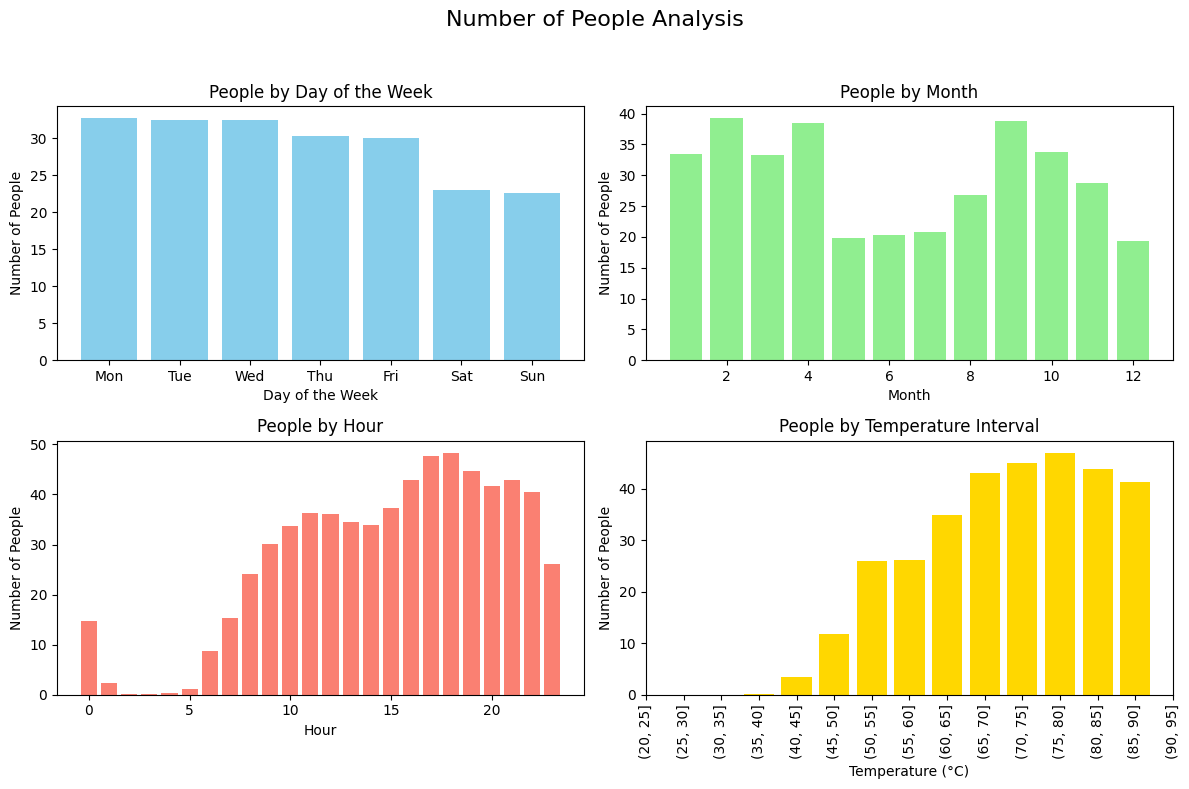

In [63]:
import matplotlib.ticker as ticker # Import the ticker module

# Step 1: Calculate group-wise means
week_day_mean = gym_c.groupby('day_of_week')['number_people'].mean()
month_mean = gym_c.groupby('month')['number_people'].mean()
hour_mean = gym_c.groupby('hour')['number_people'].mean()

# Step 2: Create temperature bins and calculate means
temp_bins = range(20, 100, 5)  # Define bins for temperature
gym_c['temperature_bins'] = pd.cut(gym_c['temperature'], temp_bins)
temperature_mean = gym_c.groupby('temperature_bins', observed = False)['number_people'].mean()

# Step 3: Create plots
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
fig.suptitle('Number of People Analysis', fontsize=16)

# Day of the Week
axes[0, 0].bar(week_day_mean.index, week_day_mean.values, color='skyblue')
axes[0, 0].set_xlabel('Day of the Week')
axes[0, 0].set_ylabel('Number of People')
axes[0, 0].set_xticks(range(7))
axes[0, 0].set_xticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
axes[0, 0].set_title('People by Day of the Week')

# Month
axes[0, 1].bar(month_mean.index, month_mean.values, color='lightgreen')
axes[0, 1].set_xlabel('Month')
axes[0, 1].set_ylabel('Number of People')
axes[0, 1].set_title('People by Month')

# Hour
axes[1, 0].bar(hour_mean.index, hour_mean.values, color='salmon')
axes[1, 0].set_xlabel('Hour')
axes[1, 0].set_ylabel('Number of People')
axes[1, 0].set_title('People by Hour')

# Temperature
axes[1, 1].bar(temperature_mean.index.astype(str), temperature_mean.values, color='gold')
axes[1, 1].set_xlabel('Temperature (°C)')
axes[1, 1].set_ylabel('Number of People')
axes[1, 1].set_xticks(range(len(temperature_mean.index)))  # Set tick locations
axes[1, 1].set_xticklabels(temperature_mean.index.astype(str), rotation=90)
axes[1, 1].set_title('People by Temperature Interval')

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()



Inferences:


1.   People go more to the gym right after the weekend and then it falls down the number of people until sunday. Maybe it is people regreting the weekend.
2.   During summer holidays, check in at the gym falls sharply.
3.   The top gym hour interval is between 17 to 19.
4.   Until 60 farenheints, people just don't go much to the gym. When starts to get really hot, number of people drop a little.



## Getting Ready to Apply the Model
Now we have a clean dataset, and we we have analyzed it and removed any variables that we don't consider important

In [69]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

In [65]:
X = gym_c.drop(columns = ['number_people','date','temperature_bins'], axis = 1) # number_people becomes the y, the rest is useless here
y = gym_c['number_people']

**Model**: The SGDRegressor is efficient for large datasets, flexible with loss functions and regularization, and can handle scaling.
**Why scale data?** Ensuring that the features are on a similar scale is crucial for gradient-based optimization methods like Stochastic Gradient Descent (SGD) to converge efficiently. If the features have vastly different scales, some features may dominate the loss function, leading to poor model performance.

**What the StandardScaler does?**
* **Centering the data**: The StandardScaler subtracts the mean of each feature from the corresponding feature values. This ensures that the features have a mean of 0.
* **Scaling the data**: After centering the data, the StandardScaler divides each feature by its standard deviation. This ensures that all features have a standard deviation of 1.

In [76]:
scaler = StandardScaler()
model = SGDRegressor(alpha=0.0001, learning_rate='optimal', loss='huber',
    penalty='elasticnet',random_state = 42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
scaled_X_train = scaler.fit_transform(X_train)
scaled_X_test = scaler.transform(X_test)

**SGD Parameters:**

* `alpha`: Controls the strength of regularization to avoid overfitting.
* `learning_rate='optimal'`: Automatically adjusts the learning rate to ensure efficient convergence.
* `loss='huber'`: Uses a robust loss function (Huber) that is less sensitive to outliers, making it more reliable when dealing with noisy data.
* `penalty='elasticnet'`: Applies a combination of L1 and L2 regularization, which helps in feature selection and dealing with multicollinearity.

In [79]:
model.fit(scaled_X_train, y_train)

SGDRegressor(learning_rate='optimal', loss='huber', penalty='elasticnet',
             random_state=42)

## Measure the Performance of the Model

In [103]:
y_pred = model.predict(scaled_X_test)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Mean Squared Error: {mse:.2f}")
print(f"Root Mean Squared Error: {np.sqrt(mse):.2f}")
print(f"Mean Absolute Error: {mae:.2f}")
print(f"R-squared: {r2:.2f}")
print(f"Coefficients: {model.coef_}")
print(f"Intercept: {model.intercept_}")

Mean Squared Error: 254.86
Root Mean Squared Error: 15.96
Mean Absolute Error: 12.04
R-squared: 0.51
Coefficients: [-1.2067001  -2.56374156 -0.39653949  4.68643094  1.92262235  5.13550868
 -2.86004052 11.48419658]
Intercept: [27.77735736]


About 51% of the variation in 'number_people' is explained by our model. Is not a great result, but at least may help to avoid really crowd hours and even days. Lets think in an example with the table below:

In [105]:
gym_c['number_people'].describe()

,number_people
count,62184.000000
mean,29.072543
std,22.689026
min,0.000000
25%,9.000000
50%,28.000000
75%,43.000000
max,145.000000


The top 25% crowded hour shows more than 43 persons at the gym. That is really far from the **maximum value of 145**. Anyway, if our model predicts 80 persons at the gym and the root mean squared error is 15.96, probably the gym is in its peak momentum. Because, considering our model got this right, the range of people will be between 64 to 96.  

## Coefficients


In [91]:
coef_df = pd.DataFrame({'Feature': X.columns, 'Coefficient': model.coef_})
coef_df

,Feature,Coefficient
0,day_of_week,-1.206700
1,is_weekend,-2.563742
2,is_holiday,-0.396539
3,temperature,4.686431
4,is_start_of_semester,1.922622
5,is_during_semester,5.135509
6,month,-2.860041
7,hour,11.484197


By our model, the most impactful feature is, by far, the `hour` of the day. That is because the dataset counts the 24 hours and during the first 7 hours of the day, almost no one goes to the gym, so the distribution of hours is really assimetric to late hours of the day. Maybe, a better model would count just from 7 to 23 (or something like that).

`Temperature` and `is_during_semester` are really impactful positive coefficients too.

The `month` variable could be excluded. It is not showing a good fit according to the distribution we saw before. With a coefficient of -2.86, each higher month will really impact negatively the model. Like, october is a crowded month, but our model would subtract 28.6 persons from the prediction (10 * -2.86), so is not making sens.

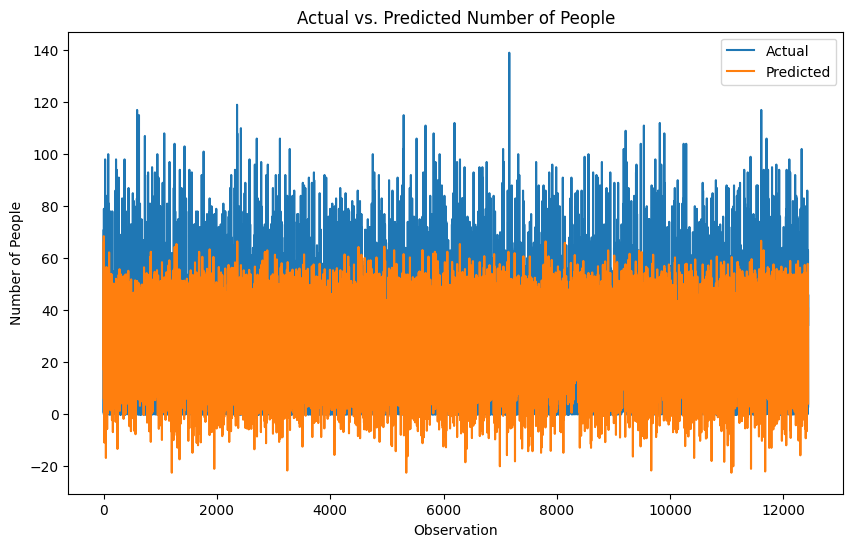

In [96]:

plt.figure(figsize=(10, 6))
x_axis = range(len(y_pred)) #
plt.plot(x_axis,y_test, label='Actual')
plt.plot(x_axis,y_pred, label='Predicted')
plt.xlabel('Observation')
plt.ylabel('Number of People')
plt.title('Actual vs. Predicted Number of People')
plt.legend()
plt.show()

By this graph, **our model underestimates the real number of persons at the gym.**
Important to notice, but the model constantly predicts negative persons at the gym, what does not make sense. The next graph will show this better.

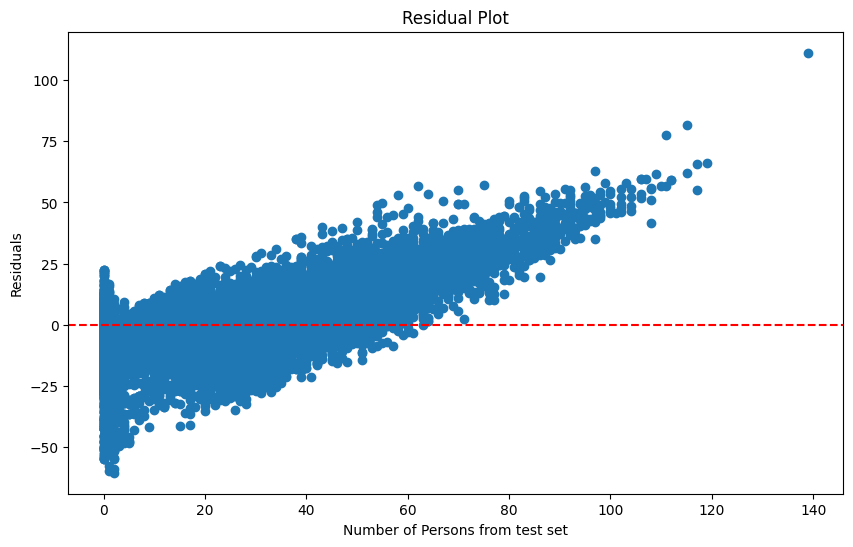

In [115]:
residuals = y_test - y_pred
plt.figure(figsize=(10, 6))
plt.scatter(y_test,residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Number of Persons from test set')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()

Looking for the distribution of residuals, our model underestimates at higher number of people and overestimate at lower number, as it is possible to see big negative residuals at the 0 Number of Persons from test set.

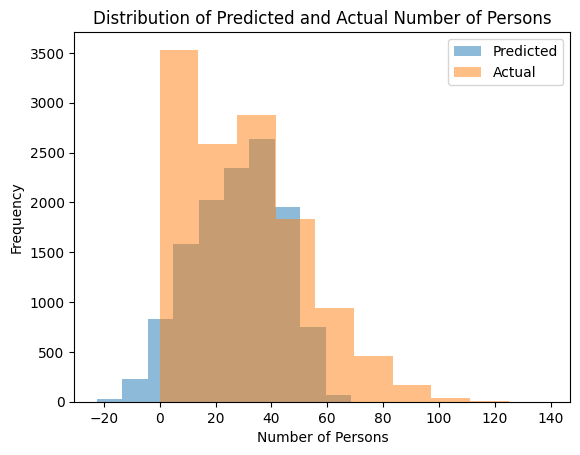

In [118]:
plt.hist(y_pred, alpha = 0.5, label = 'Predicted')
plt.hist(y_test, alpha = 0.5,label =  'Actual')
plt.legend()
plt.xlabel('Number of Persons')
plt.ylabel('Frequency')
plt.title('Distribution of Predicted and Actual Number of Persons')
plt.show()

The distribution makes clear the model results looks more similar to a normal distribution then the actual results, but thats not good, since the actual distribution is **skewed to the right as there are near 3500 hours that no one showed up o the gym and our model wasn't able to capture that.**

# Conclusion

I don't see this model as good enough to predict the number of persons at the gym at a given time. As said before, it overestimates when there aren't much persons at the gym and underestimate when the gym is crowded. It is good to predict mean values just.

To get a better model, I would first remove the `month` variable, adjust the `hours`in analysis and control for extreme values.